# Comparison between GoiStrat and naïve solution

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Imports

In [ ]:
import sys
from itertools import product
from pathlib import Path
from typing import Dict, Iterable

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from scipy.stats import ttest_rel

Setup

In [3]:
src_path: str = "/home/uziel/Development/goi-strat/src"
sys.path.insert(0, src_path)

In [4]:
from data.utils import calculate_power

In [5]:
ROOT: Path = Path("/mnt/d/phd_data/")
MSIGDB_CATS: Iterable[str] = ("H", *[f"C{i}" for i in range(1, 9)])
DATASETS_MARKERS: Dict[str, str] = {
    "TCGA-BRCA": "BRCA1",  # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8998777/
    "TCGA-LUAD": "NKX2-1",  # https://www.nature.com/articles/nature09881
    "TCGA-THCA": "HMGA2",  # https://pubmed.ncbi.nlm.nih.gov/17943974/
    "TCGA-UCEC": "PIK3CA",  # https://pubmed.ncbi.nlm.nih.gov/28860563/, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3060282/
    "TCGA-LUSC": "SOX2",  # https://www.cell.com/cancer-cell/fulltext/S1535-6108(16)30436-6
    "TCGA-KIRC": "CA9",  # https://www.sciencedirect.com/science/article/abs/pii/S0959804910006982
    "TCGA-HNSC": "TP63",  # https://aacrjournals.org/mcr/article/17/6/1279/270274/Loss-of-TP63-Promotes-the-Metastasis-of-Head-and
    "TCGA-LGG": "IDH1",  # https://www.neurology.org/doi/abs/10.1212/wnl.0b013e3181f96282
    "PCTA-WCDT": "FOLH1",  # https://www.nature.com/articles/nrurol.2016.26
}
PERCENTILES: Iterable[int] = (10, 15, 20, 25, 30)
RENAME_DICT: Dict = {
    "GOI_level": "GoiStrat",
    "GOI_level_10": "10/80/10",
    "GOI_level_15": "15/70/15",
    "GOI_level_20": "20/60/20",
    "GOI_level_25": "25/50/25",
    "GOI_level_30": "30/40/30",
}
SAMPLE_TYPE: str = "prim"
PALETTE_STR: str = "coolwarm"  # coolwarm or flare
EFFECT_SIZE: float = 0.5
ALPHA: float = 0.05

sns.set_theme(style="whitegrid", palette=PALETTE_STR)
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Ubuntu Mono"
plt.rcParams["font.monospace"] = "Ubuntu Mono"

Global variables

In [6]:
MULTI_DATASET_PATH: Path = ROOT.joinpath("MULTI_DATASET")
MULTI_DATASET_PATH.mkdir(parents=True, exist_ok=True)

## 1. Explore dataset characteristics

### 1.1. Annotation data from all splits

In [7]:
group_counts = dict()
for dataset, marker in DATASETS_MARKERS.items():
    data_root = ROOT.joinpath(f"{dataset}_{marker}")
    annot_df = pd.read_csv(
        data_root.joinpath("data").joinpath(f"samples_annotation_{marker}_gsva.csv"),
        index_col=0,
    )
    contrast_factor = f"{marker}_level"
    group_counts[(dataset + f" ({marker})", "GOI_level")] = (
        annot_df[contrast_factor].value_counts().to_dict()
    )
    group_counts[(dataset + f" ({marker})", "GOI_level")].update(
        {"total": len(annot_df)}
    )

    for percentile in PERCENTILES:
        annot_df = pd.read_csv(
            data_root.joinpath("data").joinpath(
                f"samples_annotation_{marker}_perc.csv"
            ),
            index_col=0,
        )
        contrast_factor = f"{marker}_level_{percentile}"
        group_counts[(dataset + f" ({marker})", f"GOI_level_{percentile}")] = (
            annot_df[contrast_factor].value_counts().to_dict()
        )
        group_counts[(dataset + f" ({marker})", f"GOI_level_{percentile}")].update(
            {"total": len(annot_df)}
        )

group_counts_df = pd.DataFrame(group_counts).T
group_counts_df.to_csv(MULTI_DATASET_PATH.joinpath("group_counts_all_df.csv"))

In [8]:
# Function to apply calculate_power to each row
def calculate_row_power(row: pd.Series) -> float:
    """
    Calculate the test power for a given row using the low and high values.

    Parameters:
    - row: A pandas Series representing a row of the DataFrame.

    Returns:
    - float: The calculated power for the row.
    """
    return calculate_power(
        effect_size=EFFECT_SIZE, alpha=ALPHA, n1=row["low"], n2=row["high"]
    )


# Apply the function to each row and create a new column 'power'
group_counts_df["ttest_power"] = group_counts_df.apply(calculate_row_power, axis=1)

group_counts_df.to_csv(MULTI_DATASET_PATH.joinpath("group_counts_df_with_power.csv"))

In [9]:
# Unstack the second level of the row index to columns
group_counts_df_unstacked = group_counts_df.unstack(level=1)

# Swap the levels of the column index
group_counts_df_unstacked.columns = group_counts_df_unstacked.columns.swaplevel(0, 1)

# Sort the MultiIndex
group_counts_df_unstacked = group_counts_df_unstacked.sort_index(
    level=[0, 1], axis=1, ascending=[True, True]
)

group_counts_df_unstacked.columns = group_counts_df_unstacked.columns.set_levels(
    group_counts_df_unstacked.columns.levels[0].map(RENAME_DICT), level=0
)

group_counts_df_unstacked = group_counts_df_unstacked.stack()

# Display the transformed DataFrame
display(group_counts_df_unstacked)

group_counts_df_unstacked.to_latex(
    MULTI_DATASET_PATH / "table_1.tex",
    bold_rows=True,
    caption="Group sizes after multiple splitting strategies.",
    label="table1",
)

/tmp/ipykernel_475921/2400084081.py:16: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  group_counts_df_unstacked = group_counts_df_unstacked.stack()


GoiStrat     10/80/10     15/70/15  \
PCTA-WCDT (FOLH1)  high           90.000000    67.000000   100.000000   
                   low           241.000000    67.000000   100.000000   
                   mid           331.000000   528.000000   462.000000   
                   total         662.000000   662.000000   662.000000   
                   ttest_power     0.981038     0.819348     0.940427   
TCGA-BRCA (BRCA1)  high          133.000000   111.000000   166.000000   
                   low           420.000000   111.000000   166.000000   
                   mid           553.000000   884.000000   774.000000   
                   total        1106.000000  1106.000000  1106.000000   
                   ttest_power     0.998880     0.959824     0.995088   
TCGA-HNSC (TP63)   high           61.000000    52.000000    78.000000   
                   low           199.000000    52.000000    78.000000   
                   mid           260.000000   416.000000   364.000000   
                   total         520.000000   520.000000   520.000000   
                   ttest_power     0.925594     0.714129     0.873482   
TCGA-KIRC (CA9)    high           53.000000    54.000000    81.000000   
                   low           216.000000    54.000000    81.000000   
                   mid           268.000000   429.000000   375.000000   
                   total         537.000000   537.000000   537.000000   
                   ttest_power     0.901491     0.730564     0.885485   
TCGA-LGG (IDH1)    high          207.000000    52.000000    78.000000   
                   low            51.000000    52.000000    78.000000   
                   mid           258.000000   412.000000   360.000000   
                   total         516.000000   516.000000   516.000000   
                   ttest_power     0.889976     0.714129     0.873482   
TCGA-LUAD (NKX2-1) high           52.000000    53.000000    80.000000   
                   low           212.000000    53.000000    80.000000   
                   mid           264.000000   422.000000   368.000000   
                   total         528.000000   528.000000   528.000000   
                   ttest_power     0.896017     0.722445     0.881602   
TCGA-LUSC (SOX2)   high           54.000000    50.000000    75.000000   
                   low           197.000000    50.000000    75.000000   
                   mid           250.000000   401.000000   351.000000   
                   total         501.000000   501.000000   501.000000   
                   ttest_power     0.900175     0.696893     0.860368   
TCGA-THCA (HMGA2)  high          202.000000    51.000000    76.000000   
                   low            51.000000    51.000000    76.000000   
                   mid           252.000000   403.000000   353.000000   
                   total         505.000000   505.000000   505.000000   
                   ttest_power     0.888462     0.705613     0.864867   
TCGA-UCEC (PIK3CA) high          221.000000    55.000000    83.000000   
                   low            54.000000    55.000000    83.000000   
                   mid           274.000000   439.000000   383.000000   
                   total         549.000000   549.000000   549.000000   
                   ttest_power     0.906953     0.738487     0.892908   

                                   20/60/20     25/50/25     30/40/30  
PCTA-WCDT (FOLH1)  high          133.000000   166.000000   199.000000  
                   low           133.000000   166.000000   199.000000  
                   mid           396.000000   330.000000   264.000000  
                   total         662.000000   662.000000   662.000000  
                   ttest_power     0.982247     0.995088     0.998717  
TCGA-BRCA (BRCA1)  high          221.000000   277.000000   332.000000  
                   low           221.000000   277.000000   332.000000  
                   mid           664.000000   552.000000   442.000000  
                   total    

In [10]:
power_map = group_counts_df["ttest_power"].to_dict()
print(power_map)

{('TCGA-BRCA (BRCA1)', 'GOI_level'): 0.9988803442132566, ('TCGA-BRCA (BRCA1)', 'GOI_level_10'): 0.9598236158634741, ('TCGA-BRCA (BRCA1)', 'GOI_level_15'): 0.9950879206127476, ('TCGA-BRCA (BRCA1)', 'GOI_level_20'): 0.9994891339216804, ('TCGA-BRCA (BRCA1)', 'GOI_level_25'): 1.0, ('TCGA-BRCA (BRCA1)', 'GOI_level_30'): 1.0, ('TCGA-LUAD (NKX2-1)', 'GOI_level'): 0.8960165794812585, ('TCGA-LUAD (NKX2-1)', 'GOI_level_10'): 0.7224452892573963, ('TCGA-LUAD (NKX2-1)', 'GOI_level_15'): 0.8816024847721196, ('TCGA-LUAD (NKX2-1)', 'GOI_level_20'): 0.9518832387085298, ('TCGA-LUAD (NKX2-1)', 'GOI_level_25'): 0.9815614364531526, ('TCGA-LUAD (NKX2-1)', 'GOI_level_30'): 0.9935148960423404, ('TCGA-THCA (HMGA2)', 'GOI_level'): 0.8884624463286505, ('TCGA-THCA (HMGA2)', 'GOI_level_10'): 0.7056125740521042, ('TCGA-THCA (HMGA2)', 'GOI_level_15'): 0.8648673142097211, ('TCGA-THCA (HMGA2)', 'GOI_level_20'): 0.9424975311351828, ('TCGA-THCA (HMGA2)', 'GOI_level_25'): 0.9768896517490835, ('TCGA-THCA (HMGA2)', 'GOI_le

## 2. Gather and compare differential expression results

Differential expression results between low and high groups for each dataset and splitting strategy.

In [11]:
all_degs = dict()
all_degs_scores = dict()
for dataset, marker in DATASETS_MARKERS.items():
    contrast_factors = [
        f"{marker}_level_{percentile}" for percentile in PERCENTILES
    ] + [f"{marker}_level"]
    data_root = ROOT.joinpath(f"{dataset}_{marker}")

    for contrast_factor in contrast_factors:
        deseq_results = pd.read_csv(
            data_root.joinpath("deseq2").joinpath(
                f"sample_type_{SAMPLE_TYPE}_{contrast_factor}_"
                f"{SAMPLE_TYPE}_high+{SAMPLE_TYPE}_low_"
                f"_{SAMPLE_TYPE}_high_vs_{SAMPLE_TYPE}_low_"
                "padj_0_05_all_1_0_deseq_results_unique.csv"
            ),
            index_col=0,
        )
        contrast_factor_str = contrast_factor.replace(marker, "GOI")
        all_degs[(dataset + f" ({marker})", contrast_factor_str)] = deseq_results[
            "log2FoldChange"
        ]
        all_degs_scores[(dataset + f" ({marker})", contrast_factor_str)] = (
            deseq_results[
                "log2FoldChange"
            ].pipe(lambda x: np.sqrt(np.mean(np.power(x, 2))))
        )

all_degs_df = pd.DataFrame(all_degs)

In [12]:
all_degs_scores_df = pd.Series(all_degs_scores).unstack(level=0).transpose()
all_degs_scores_df.to_csv(MULTI_DATASET_PATH.joinpath("all_degs_scores_df.csv"))
display(all_degs_scores_df)

,GOI_level,GOI_level_10,GOI_level_15,GOI_level_20,GOI_level_25,GOI_level_30
PCTA-WCDT (FOLH1),1.523208,1.724276,1.597775,1.571454,1.508589,1.479444
TCGA-BRCA (BRCA1),1.531838,1.633386,1.624730,1.780670,1.740930,1.774753
TCGA-HNSC (TP63),1.483313,1.598803,1.541048,1.481256,1.474818,1.442893
TCGA-KIRC (CA9),1.896113,2.267806,2.327118,2.354664,2.323584,2.206625
TCGA-LGG (IDH1),1.781794,1.878264,1.786128,1.681172,1.612114,1.537598
TCGA-LUAD (NKX2-1),1.947659,2.276284,2.178660,2.110323,2.083919,2.007937
TCGA-LUSC (SOX2),1.795002,1.999208,1.926709,1.873019,1.822779,1.799866
TCGA-THCA (HMGA2),2.315340,2.330369,2.117451,1.950802,1.905669,1.838849
TCGA-UCEC (PIK3CA),1.616146,1.823093,1.735578,1.711255,1.680427,1.631354


In [13]:
def apply_function(df, func):
    for row_idx, row in df.iterrows():
        for col_idx, value in row.items():
            df.at[row_idx, col_idx] = value * func[(row_idx, col_idx)]
    return df


all_degs_scores_df_weighted = apply_function(all_degs_scores_df, power_map)
all_degs_scores_df_weighted.to_csv(
    MULTI_DATASET_PATH.joinpath("all_degs_scores_df_weighted.csv")
)
display(all_degs_scores_df_weighted)

,GOI_level,GOI_level_10,GOI_level_15,GOI_level_20,GOI_level_25,GOI_level_30
PCTA-WCDT (FOLH1),1.494325,1.412781,1.502591,1.543556,1.501179,1.477546
TCGA-BRCA (BRCA1),1.530123,1.567762,1.616749,1.779760,1.740930,1.774753
TCGA-HNSC (TP63),1.372945,1.141752,1.346077,1.404697,1.445491,1.432361
TCGA-KIRC (CA9),1.709328,1.656777,2.060628,2.249224,2.283869,2.193403
TCGA-LGG (IDH1),1.585753,1.341323,1.560151,1.591127,1.578825,1.525925
TCGA-LUAD (NKX2-1),1.745135,1.644491,1.920712,2.008781,2.045494,1.994915
TCGA-LUSC (SOX2),1.615815,1.393235,1.657678,1.761438,1.779049,1.783249
TCGA-THCA (HMGA2),2.057093,1.644337,1.831314,1.838626,1.861628,1.823148
TCGA-UCEC (PIK3CA),1.465768,1.346329,1.549712,1.639966,1.654806,1.623015


In [14]:
all_degs_scores_df_weighted_ranked = all_degs_scores_df_weighted.rank(
    axis=1, method="max", ascending=False
).astype(int)
all_degs_scores_df_weighted_ranked.to_csv(
    MULTI_DATASET_PATH.joinpath("all_degs_scores_df_weighted_ranked.csv")
)
display(all_degs_scores_df_weighted_ranked)

,GOI_level,GOI_level_10,GOI_level_15,GOI_level_20,GOI_level_25,GOI_level_30
PCTA-WCDT (FOLH1),4,6,2,1,3,5
TCGA-BRCA (BRCA1),6,5,4,1,3,2
TCGA-HNSC (TP63),4,6,5,3,1,2
TCGA-KIRC (CA9),5,6,4,2,1,3
TCGA-LGG (IDH1),2,6,4,1,3,5
TCGA-LUAD (NKX2-1),5,6,4,2,1,3
TCGA-LUSC (SOX2),5,6,4,3,2,1
TCGA-THCA (HMGA2),1,6,4,3,2,5
TCGA-UCEC (PIK3CA),5,6,4,2,1,3


In [15]:
all_degs_scores_df_weighted_ranked_summary = (
    all_degs_scores_df_weighted_ranked.median().sort_values(ascending=True)
)
all_degs_scores_df_weighted_ranked_summary.to_csv(
    MULTI_DATASET_PATH.joinpath("all_degs_scores_df_weighted_ranked_summary.csv")
)
display(all_degs_scores_df_weighted_ranked_summary)

GOI_level_20    2.0
GOI_level_25    2.0
GOI_level_30    3.0
GOI_level_15    4.0
GOI_level       5.0
GOI_level_10    6.0
dtype: float64

### 2.1. Visualise results

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


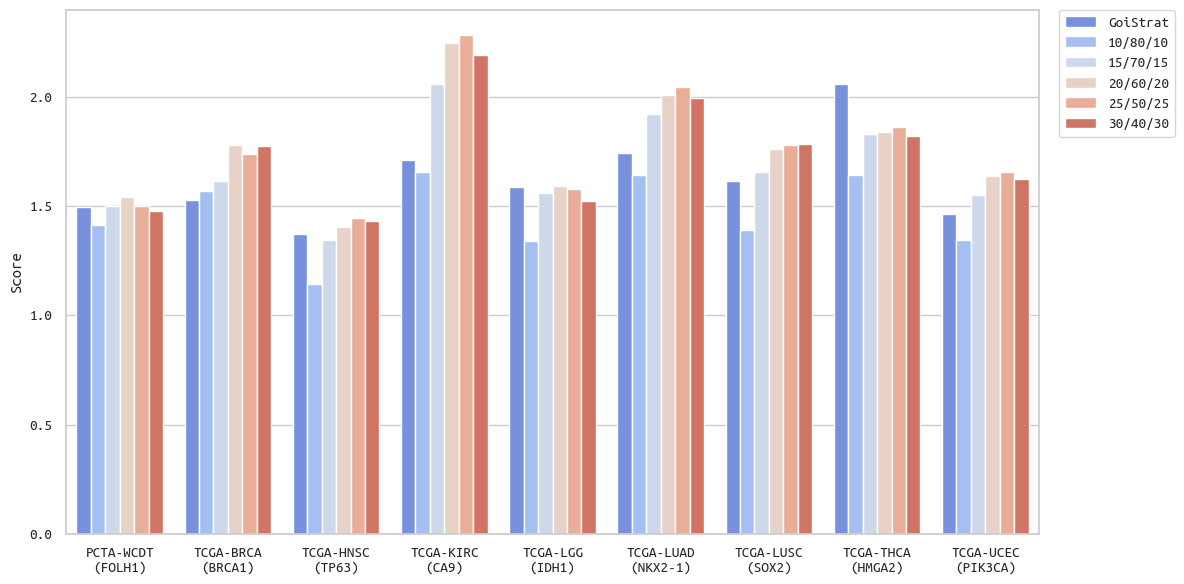

In [16]:
# Melt the DataFrame to long format for seaborn
all_degs_scores_df_weighted_melted = all_degs_scores_df_weighted.reset_index().melt(
    id_vars="index", var_name="Column", value_name="Score"
)

all_degs_scores_df_weighted_melted["Column"] = all_degs_scores_df_weighted_melted[
    "Column"
].map(RENAME_DICT)
all_degs_scores_df_weighted_melted["index"] = all_degs_scores_df_weighted_melted[
    "index"
].str.replace(" (", "\n(")

# Create the barplot
plt.figure(figsize=(12, 6))
barplot = sns.barplot(
    data=all_degs_scores_df_weighted_melted,
    x="index",
    y="Score",
    hue="Column",
    palette=PALETTE_STR,
)

# Customize the plot
plt.xlabel("")
plt.ylabel("Score")
# plt.title(
#    "Weighted Root-mean-squared LFC scores of DEGs for different GOI splitting strategies"
# )

# Add a black border to the bar corresponding to "GOI_level"
for patch, level in zip(barplot.patches, all_degs_scores_df_weighted_melted["Column"]):
    if level == "GoiStrat (*/50/*)":
        patch.set_edgecolor("black")
        patch.set_linewidth(1)

# Move the legend outside of the figure
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.0)

# Show the plot
plt.tight_layout()

plt.savefig(
    MULTI_DATASET_PATH.joinpath("all_degs_scores_df_weighted_barplot.pdf"),
    bbox_inches="tight",
)
plt.savefig(
    MULTI_DATASET_PATH.joinpath("all_degs_scores_df_weighted_barplot.eps"),
    bbox_inches="tight",
)

plt.show()

## 3. Gather and compare differential enrichment results

Differential enrichment results between low and high groups for each dataset and splitting strategy.

In [17]:
all_degss = dict()
all_degss_scores = dict()
for dataset, marker in DATASETS_MARKERS.items():
    contrast_factors = [
        f"{marker}_level_{percentile}" for percentile in PERCENTILES
    ] + [f"{marker}_level"]
    data_root = ROOT.joinpath(f"{dataset}_{marker}")
    msigdb_cats_meta_dfs = {
        msigdb_cat: pd.read_csv(
            ROOT.joinpath(dataset)
            .joinpath("data")
            .joinpath("gsva")
            .joinpath(f"{msigdb_cat}_meta.csv"),
            index_col=0,
        )
        for msigdb_cat in MSIGDB_CATS
    }

    for contrast_factor, msigdb_cat in product(contrast_factors, MSIGDB_CATS):
        gsva_results = pd.read_csv(
            data_root.joinpath("diff_gsva")
            .joinpath(msigdb_cat)
            .joinpath(
                f"sample_type_{SAMPLE_TYPE}_{contrast_factor}_"
                f"{SAMPLE_TYPE}_high+{SAMPLE_TYPE}_low_"
                f"_{SAMPLE_TYPE}_high_vs_{SAMPLE_TYPE}_low_"
                "top_table_padj_0_05_all_0_0.csv"
            ),
            index_col=0,
        )
        contrast_factor_str = contrast_factor.replace(marker, "GOI")
        all_degss[(dataset + f" ({marker})", contrast_factor_str, msigdb_cat)] = (
            gsva_results["log2FoldChange"]
        )
        all_degss_scores[
            (dataset + f" ({marker})", contrast_factor_str, msigdb_cat)
        ] = gsva_results["log2FoldChange"].pipe(
            lambda x: (x.count() / len(msigdb_cats_meta_dfs[msigdb_cat]))
            * np.sqrt(np.mean(np.power(x, 2)))
        )

all_degss_df = pd.DataFrame(all_degss)

In [18]:
all_degss_scores_df = (
    pd.Series(all_degss_scores).unstack(level=[0, 1]).median().unstack()
)
all_degss_scores_df.to_csv(MULTI_DATASET_PATH.joinpath("all_degss_scores_df.csv"))
display(all_degss_scores_df)

,GOI_level,GOI_level_10,GOI_level_15,GOI_level_20,GOI_level_25,GOI_level_30
PCTA-WCDT (FOLH1),0.142125,0.133210,0.137942,0.131065,0.122510,0.108408
TCGA-BRCA (BRCA1),0.145028,0.142305,0.144640,0.140454,0.132897,0.130434
TCGA-HNSC (TP63),0.099136,0.097009,0.091157,0.092526,0.084081,0.081235
TCGA-KIRC (CA9),0.098297,0.110873,0.094056,0.086699,0.082785,0.079951
TCGA-LGG (IDH1),0.125393,0.140012,0.124962,0.111795,0.101627,0.092250
TCGA-LUAD (NKX2-1),0.105013,0.101345,0.089102,0.088880,0.089804,0.086732
TCGA-LUSC (SOX2),0.147486,0.163678,0.149648,0.130866,0.122489,0.118642
TCGA-THCA (HMGA2),0.157505,0.144311,0.149260,0.134433,0.123261,0.116138
TCGA-UCEC (PIK3CA),0.135823,0.146615,0.139929,0.133837,0.124633,0.114628


In [19]:
def apply_function(df, func):
    for row_idx, row in df.iterrows():
        for col_idx, value in row.items():
            df.at[row_idx, col_idx] = value * func[(row_idx, col_idx)]
    return df


all_degss_scores_df_weighted = apply_function(all_degss_scores_df, power_map)
all_degss_scores_df_weighted.to_csv(
    MULTI_DATASET_PATH.joinpath("all_degss_scores_df_weighted.csv")
)
display(all_degss_scores_df_weighted)

,GOI_level,GOI_level_10,GOI_level_15,GOI_level_20,GOI_level_25,GOI_level_30
PCTA-WCDT (FOLH1),0.139430,0.109146,0.129724,0.128738,0.121908,0.108269
TCGA-BRCA (BRCA1),0.144865,0.136588,0.143930,0.140382,0.132897,0.130434
TCGA-HNSC (TP63),0.091760,0.069277,0.079624,0.087744,0.082409,0.080642
TCGA-KIRC (CA9),0.088614,0.081000,0.083285,0.082816,0.081370,0.079472
TCGA-LGG (IDH1),0.111597,0.099987,0.109152,0.105807,0.099529,0.091550
TCGA-LUAD (NKX2-1),0.094093,0.073216,0.078552,0.084604,0.088148,0.086169
TCGA-LUSC (SOX2),0.132763,0.114066,0.128752,0.123070,0.119550,0.117547
TCGA-THCA (HMGA2),0.139937,0.101828,0.129090,0.126703,0.120413,0.115147
TCGA-UCEC (PIK3CA),0.123185,0.108273,0.124944,0.128262,0.122733,0.114042


In [20]:
all_degss_scores_df_weighted_ranked = all_degss_scores_df_weighted.rank(
    axis=1, method="max", ascending=False
).astype(int)
all_degss_scores_df_weighted_ranked.to_csv(
    MULTI_DATASET_PATH.joinpath("all_degss_scores_df_weighted_ranked.csv")
)
display(all_degss_scores_df_weighted_ranked)

,GOI_level,GOI_level_10,GOI_level_15,GOI_level_20,GOI_level_25,GOI_level_30
PCTA-WCDT (FOLH1),1,5,2,3,4,6
TCGA-BRCA (BRCA1),1,4,2,3,5,6
TCGA-HNSC (TP63),1,6,5,2,3,4
TCGA-KIRC (CA9),1,5,2,3,4,6
TCGA-LGG (IDH1),1,4,2,3,5,6
TCGA-LUAD (NKX2-1),1,6,5,4,2,3
TCGA-LUSC (SOX2),1,6,2,3,4,5
TCGA-THCA (HMGA2),1,6,2,3,4,5
TCGA-UCEC (PIK3CA),3,6,2,1,4,5


In [21]:
all_degss_scores_df_weighted_ranked_summary = (
    all_degss_scores_df_weighted_ranked.median().sort_values(ascending=True)
)
all_degss_scores_df_weighted_ranked_summary.to_csv(
    MULTI_DATASET_PATH.joinpath("all_degss_scores_df_weighted_ranked_summary.csv")
)
display(all_degss_scores_df_weighted_ranked_summary)

GOI_level       1.0
GOI_level_15    2.0
GOI_level_20    3.0
GOI_level_25    4.0
GOI_level_30    5.0
GOI_level_10    6.0
dtype: float64

### 3.1. Visualise results

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


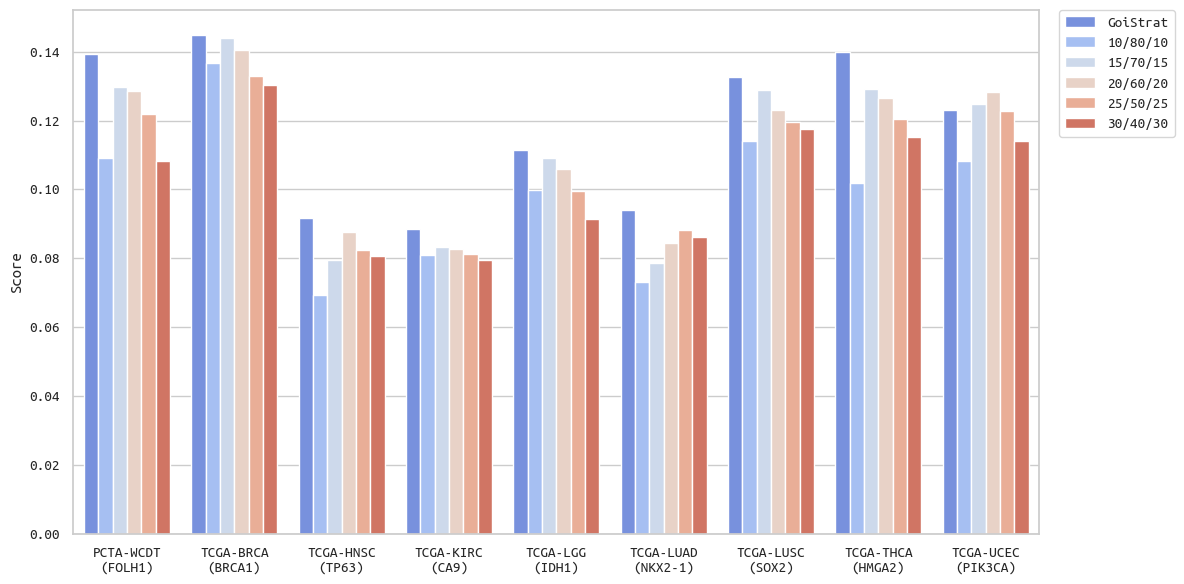

In [22]:
# Melt the DataFrame to long format for seaborn
all_degss_scores_df_weighted_melted = all_degss_scores_df_weighted.reset_index().melt(
    id_vars="index", var_name="Column", value_name="Score"
)
all_degss_scores_df_weighted_melted["index"] = all_degss_scores_df_weighted_melted[
    "index"
].str.replace(" (", "\n(")

all_degss_scores_df_weighted_melted["Column"] = all_degss_scores_df_weighted_melted[
    "Column"
].map(RENAME_DICT)

# Create the barplot
plt.figure(figsize=(12, 6))
barplot = sns.barplot(
    data=all_degss_scores_df_weighted_melted,
    x="index",
    y="Score",
    hue="Column",
    palette=PALETTE_STR,
)

# Customize the plot
plt.xlabel("")
plt.ylabel("Score")
# plt.title(
#    "Weighted Median Functional Enrichment Scores for different GOI splitting strategies"
# )

# Add a black border to the bar corresponding to "GOI_level"
for patch, level in zip(barplot.patches, all_degss_scores_df_weighted_melted["Column"]):
    if level == "GoiStrat (*/50/*)":
        patch.set_edgecolor("black")
        patch.set_linewidth(1)

# Move the legend outside of the figure
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.0)

# Show the plot
plt.tight_layout()

plt.savefig(
    MULTI_DATASET_PATH.joinpath("all_degss_scores_df_weighted_barplot.pdf"),
    bbox_inches="tight",
)
plt.savefig(
    MULTI_DATASET_PATH.joinpath("all_degss_scores_df_weighted_barplot.eps"),
    bbox_inches="tight",
)

plt.show()

### 3.2. Compute statistical significance between strategies

The paired t-test, also known as the dependent t-test or the t-test for paired samples, is a statistical test used to determine whether there is a significant difference between the means of two related groups. It is commonly used when the observations in one group are paired with observations in another group, such as before-and-after measurements on the same subjects.

#### Hypotheses

The paired t-test tests the following hypotheses:

- **Null Hypothesis (H0)**: The mean difference between the paired observations is zero. In other words, there is no significant difference between the means of the two groups.
  
  \( H_0: \mu_D = 0 \)

- **Alternative Hypothesis (H1)**: The mean difference between the paired observations is not zero. In other words, there is a significant difference between the means of the two groups.
  
  \( H_1: \mu_D \neq 0 \)

Where \( \mu_D \) is the mean of the differences between the paired observations.

In [28]:
# Initialize a list to store p-values
p_values = []

# Get the first column
first_column = all_degss_scores_df_weighted.iloc[:, 0]

# Iterate over the other columns and perform one-tailed paired t-test
for col in all_degss_scores_df_weighted.columns[1:]:
    other_column = all_degss_scores_df_weighted[col]
    t_stat, p_value = ttest_rel(first_column, other_column)

    # Adjust p-value for one-tailed test
    if t_stat > 0:
        p_value /= 2
    else:
        p_value = 1 - (p_value / 2)

    p_values.append(p_value)

# Create a DataFrame to display the results
all_degss_scores_df_weighted_p_values = pd.DataFrame(
    {"Column": all_degss_scores_df_weighted.columns[1:], "P-Value": p_values}
)

# Display the results
display(all_degss_scores_df_weighted_p_values)

,Column,P-Value
0,GOI_level_10,0.000233
1,GOI_level_15,0.004524
2,GOI_level_20,0.003321
3,GOI_level_25,0.000278
4,GOI_level_30,0.000167


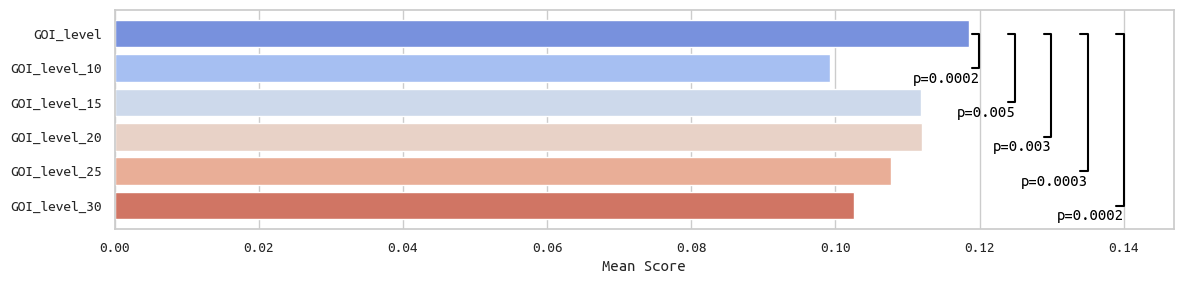

In [77]:
# Calculate the mean of each column
means = all_degss_scores_df_weighted.mean()

# Create the barplot
plt.figure(figsize=(12, 3))
barplot = sns.barplot(y=means.index, x=means.values, palette=PALETTE_STR)

# Get the width of the first bar
first_bar_width = means.iloc[0]

# Annotate the plot with p-values and lines
offset = 0.0005  # Initial offset
for i, (col, p_value) in enumerate(
    zip(
        all_degss_scores_df_weighted.columns[1:],
        all_degss_scores_df_weighted_p_values["P-Value"],
    )
):
    bar_width = means[col]
    y1, y2 = 0, i + 1  # Indices of the bars to connect
    x, h, col = (
        first_bar_width + offset,
        0.001,
        "k",
    )  # x position, height of the line, color
    plt.plot([x, x + h, x + h, x], [y1, y1, y2, y2], lw=1.5, c=col)
    plt.text(x + h, y2 + 0.1, f"p={p_value:.1}", ha="right", va="top", color=col)
    offset += 0.005  # Increment the offset for the next annotation

# Customize the plot
plt.ylabel("")
plt.xlabel("Mean Score")

# Show the plot
plt.tight_layout()

plt.savefig(
    MULTI_DATASET_PATH.joinpath("all_degss_scores_df_weighted_p_values.pdf"),
    bbox_inches="tight",
)
plt.savefig(
    MULTI_DATASET_PATH.joinpath("all_degss_scores_df_weighted_p_values.eps"),
    bbox_inches="tight",
)

plt.show()

## 4. Gather and compare GSEA results

GSEA results between low and high groups for each dataset and splitting strategy.

In [ ]:
all_gsea = dict()
all_gsea_scores = dict()
for dataset, marker in DATASETS_MARKERS.items():
    contrast_factors = [
        f"{marker}_level_{percentile}" for percentile in PERCENTILES
    ] + [f"{marker}_level"]
    data_root = ROOT.joinpath(f"{dataset}_{marker}")
    msigdb_cats_meta_dfs = {
        msigdb_cat: pd.read_csv(
            ROOT.joinpath(dataset)
            .joinpath("data")
            .joinpath("gsva")
            .joinpath(f"{msigdb_cat}_meta.csv"),
            index_col=0,
        )
        for msigdb_cat in MSIGDB_CATS
    }

    for contrast_factor, msigdb_cat in product(contrast_factors, MSIGDB_CATS):
        gsea_results = pd.read_csv(
            data_root.joinpath("functional").joinpath(
                f"sample_type_{SAMPLE_TYPE}_{contrast_factor}_"
                f"{SAMPLE_TYPE}_high+{SAMPLE_TYPE}_low_"
                f"_{SAMPLE_TYPE}_high_vs_{SAMPLE_TYPE}_low_"
                f"gsea_{msigdb_cat}.csv"
            ),
            index_col=0,
        )
        contrast_factor_str = contrast_factor.replace(marker, "GOI")
        all_gsea[(dataset + f" ({marker})", contrast_factor_str, msigdb_cat)] = (
            gsea_results["enrichmentScore"]
        )
        all_gsea_scores[(dataset + f" ({marker})", contrast_factor_str, msigdb_cat)] = (
            gsea_results[
                "enrichmentScore"
            ].pipe(
                lambda x: (x.count() / len(msigdb_cats_meta_dfs[msigdb_cat]))
                * np.sqrt(np.mean(np.power(x, 2)))
            )
        )

all_gsea_df = pd.DataFrame(all_gsea)

In [ ]:
all_gsea_scores_df = pd.Series(all_gsea_scores).unstack(level=[0, 1]).median().unstack()
all_gsea_scores_df.to_csv(MULTI_DATASET_PATH.joinpath("all_gsea_scores_df.csv"))
display(all_gsea_scores_df)

In [ ]:
def apply_function(df, func):
    for row_idx, row in df.iterrows():
        for col_idx, value in row.items():
            df.at[row_idx, col_idx] = value * func[(row_idx, col_idx)]
    return df


all_gsea_scores_df_weighted = apply_function(all_gsea_scores_df, power_map)
all_gsea_scores_df_weighted.to_csv(
    MULTI_DATASET_PATH.joinpath("all_gsea_scores_df_weighted.csv")
)
display(all_gsea_scores_df_weighted)

In [ ]:
all_gsea_scores_df_weighted_ranked = all_gsea_scores_df_weighted.rank(
    axis=1, method="max", ascending=False
).astype(int)
all_gsea_scores_df_weighted_ranked.to_csv(
    MULTI_DATASET_PATH.joinpath("all_gsea_scores_df_weighted_ranked.csv")
)
display(all_gsea_scores_df_weighted_ranked)

In [ ]:
all_gsea_scores_df_weighted_ranked_summary = (
    all_gsea_scores_df_weighted_ranked.median().sort_values(ascending=True)
)
all_gsea_scores_df_weighted_ranked_summary.to_csv(
    MULTI_DATASET_PATH.joinpath("all_gsea_scores_df_weighted_ranked_summary.csv")
)
display(all_gsea_scores_df_weighted_ranked_summary)

### 3.1. Visualise results

In [ ]:
# Melt the DataFrame to long format for seaborn
all_gsea_scores_df_weighted_melted = all_gsea_scores_df_weighted.reset_index().melt(
    id_vars="index", var_name="Column", value_name="Score"
)
all_gsea_scores_df_weighted_melted["index"] = all_gsea_scores_df_weighted_melted[
    "index"
].str.replace(" (", "\n(")

all_gsea_scores_df_weighted_melted["Column"] = all_gsea_scores_df_weighted_melted[
    "Column"
].map(RENAME_DICT)

# Create the barplot
plt.figure(figsize=(12, 6))
barplot = sns.barplot(
    data=all_gsea_scores_df_weighted_melted,
    x="index",
    y="Score",
    hue="Column",
    palette=PALETTE_STR,
)

# Customize the plot
plt.xlabel("")
plt.ylabel("Score")
# plt.title(
#    "Weighted Median Functional Enrichment Scores for different GOI splitting strategies"
# )

# Add a black border to the bar corresponding to "GOI_level"
for patch, level in zip(barplot.patches, all_gsea_scores_df_weighted_melted["Column"]):
    if level == "GoiStrat (*/50/*)":
        patch.set_edgecolor("black")
        patch.set_linewidth(1)

# Move the legend outside of the figure
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.0)

# Show the plot
plt.tight_layout()

plt.savefig(
    MULTI_DATASET_PATH.joinpath("all_gsea_scores_df_weighted_barplot.pdf"),
    bbox_inches="tight",
)
plt.savefig(
    MULTI_DATASET_PATH.joinpath("all_gsea_scores_df_weighted_barplot.eps"),
    bbox_inches="tight",
)

plt.show()